# Analysis of Historical PPR ADP and Fantasy PPG

In this analysis, I look at historical ADP (Average Draft Position) for PPR (Point per Reception) Fantasy Football Leagues along side the Fantasy PPG (Points per Game) accumulated by players of each position group by draft round.

The goal for this analysis is to find where value in drafts exist - are there specific rounds in which we should target certain positions? Are there positions we can wait on in certain rounds because the drop off in PPG isn't as steep? I want to find where the edge (if any) exists in fantasy drafts by looking at historical production.

In [120]:
import requests
from pandas import DataFrame
from bs4 import BeautifulSoup as Soup
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

I will begin by creating a scraper for draft ADP. I am using Fantasy Football Calculators ADP for my data.

In [24]:
ffc_base_url = 'https://fantasyfootballcalculator.com'

def scrape_adp(scoring, nteams, year):
    # build URL based on arguments
    ffc_url = (ffc_base_url + '/adp' + _scoring_helper(scoring) +
               f'/{nteams}-team/all/{year}')
    ffc_response = requests.get(ffc_url)

    adp_soup = Soup(ffc_response.text)
    tables = adp_soup.find_all('table')
    adp_table = tables[0]
    rows = adp_table.find_all('tr')

    # move parse_row to own helper function
    list_of_parsed_rows = [_parse_row(row) for row in rows[1:]]

    # put it in a dataframe
    df = DataFrame(list_of_parsed_rows)

    # clean up formatting
    df.columns = ['ovr', 'pick', 'name', 'pos', 'team', 'adp', 'std_dev',
                'high', 'low', 'drafted', 'graph']

    float_cols =['adp', 'std_dev']
    int_cols =['ovr', 'drafted']

    df[float_cols] = df[float_cols].astype(float)
    df[int_cols] = df[int_cols].astype(int)

    df.drop('graph', axis=1, inplace=True)

    return df

# helper functions - just moving some logic to own section
def _scoring_helper(scoring):
    """
    Take a scoring system (either 'ppr'/1, 'half'/0.5, 'std'/0) and return the correct
    FFC URL fragment.

    Note: helper functions are often prefixed with _, but it's not required.
    """
    if ((scoring == 'ppr') | (scoring == 1)):
        return '/ppr'
    elif ((scoring == 'half') | (scoring == 0.5)):
        return '/half-ppr'
    elif ((scoring == 'std') | (scoring == 0)):
        return '/standard'

def _parse_row(row):
    """
    Take in a tr tag and get the data out of it in the form of a list of
    strings.
    """
    return [str(x.string) for x in row.find_all('td')]


In [356]:
test = scrape_adp(1, 12, 2022)
test.head()

,ovr,pick,name,pos,team,adp,std_dev,high,low,drafted
0,1,1.01,Jonathan Taylor,RB,IND,1.3,0.6,1.01,1.04,368
1,2,1.02,Christian McCaffrey,RB,SF,2.4,0.9,1.01,1.05,336
2,3,1.03,Austin Ekeler,RB,LAC,2.7,0.9,1.01,1.07,119
3,4,1.04,Derrick Henry,RB,TEN,4.3,1.4,1.01,1.09,277
4,5,1.05,Justin Jefferson,WR,MIN,4.6,1.4,1.01,1.09,480


Scraper looks good to me! Quick note that I did explore the ADPs returned by this site, and I wasn't satisfied in the accuracy of the 0.5ppr leagues. I will have to update this analysis for that scoring system another time. Standard and PPR looked good, and I am pursuing PPR in this analysis (who plays standard anyway?).

In [46]:
rosters = nfl.import_rosters(list(range(2013,2023)))
rosters.columns

Index(['season', 'team', 'position', 'depth_chart_position', 'jersey_number',
       'status', 'player_name', 'first_name', 'last_name', 'birth_date',
       'height', 'weight', 'college', 'player_id', 'espn_id', 'sportradar_id',
       'yahoo_id', 'rotowire_id', 'pff_id', 'pfr_id', 'fantasy_data_id',
       'sleeper_id', 'years_exp', 'headshot_url', 'ngs_position', 'week',
       'game_type', 'status_description_abbr', 'football_name', 'esb_id',
       'gsis_it_id', 'smart_id', 'entry_year', 'rookie_year', 'draft_club',
       'draft_number'],
      dtype='object')

In [48]:
ids = rosters[['player_id', 'player_name']]
ids.drop_duplicates(inplace=True)
ids

/var/folders/z9/r8xqhty9105c8rmsj1yp0t1w0000gn/T/ipykernel_3975/3515347024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ids.drop_duplicates(inplace=True)


,player_id,player_name
0,00-0026324,Mike Gibson
1,00-0025682,Lyle Sendlein
2,00-0027660,Javier Arenas
3,00-0029530,Justin Bethel
4,00-0026167,Antoine Cason
...,...,...
2628,00-0037078,Cole Turner
2629,00-0037164,Curtis Hodges
2630,00-0037168,Armani Rogers
2639,00-0037741,Jahan Dotson


Some background work above, to grab roster data. I will need this to add player names to my stats. Now, I come back to my ADP formula, and grab historical ADP from the last 10 seasons (2013-2022).

In [144]:
adp = scrape_adp(1, 12, 2022)
adp['year'] = 2022
for x in range(2021, 2012, -1):
    temp = scrape_adp(1, 12, x)
    temp['year'] = x
    adp = pd.concat([adp, temp])


In [362]:
adp.sample(5)

,ovr,pick,name,pos,team,adp,std_dev,high,low,drafted,year,round,key
101,102,9.02,Hunter Henry,TE,LAC,98.0,10.9,5.04,12.05,406,2020,9,2020Hunter Henry
4,5,1.06,Michael Thomas,WR,NO,5.6,1.6,1.01,1.11,811,2020,1,2020Michael Thomas
116,117,10.06,Keelan Cole,WR,JAX,113.9,8.5,6.08,12.01,458,2018,10,2018Keelan Cole
93,94,8.08,Sterling Shepard,WR,NYG,92.2,7.8,5.02,9.12,331,2019,8,2019Sterling Shepard
7,8,1.08,Ezekiel Elliott,RB,DAL,8.3,2.0,1.02,2.03,356,2016,1,2016Ezekiel Elliott


Looks like we're in business. Let's move on to the fantasy stats.

In [236]:
data = nfl.import_seasonal_data(list(range(2022,2012,-1)))

/Users/nrahul11/opt/anaconda3/lib/python3.9/site-packages/nfl_data_py/__init__.py:290: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  season_stats = all_stats.drop(['recent_team', 'week'], axis=1).groupby(
/Users/nrahul11/opt/anaconda3/lib/python3.9/site-packages/nfl_data_py/__init__.py:309: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  szn = data.groupby(['player_id', 'season', 'season_type']).sum().reset_index().merge(


In [238]:
data = data[['player_id', 'season', 'games', 'fantasy_points_ppr']]

In [239]:
points = pd.merge(data, ids, on='player_id', how='left')

In [240]:
points['ppg'] = round(points['fantasy_points_ppr']/points['games'],2)
points.head()

,player_id,season,games,fantasy_points_ppr,player_name,ppg
0,00-0006101,2013,16,218.90,Tony Gonzalez,13.68
1,00-0007091,2013,3,3.00,Matt Hasselbeck,1.00
2,00-0007091,2014,4,16.94,Matt Hasselbeck,4.23
3,00-0007091,2015,8,91.10,Matt Hasselbeck,11.39
4,00-0010346,2013,16,409.98,Peyton Manning,25.62


We've got both datasets in now - historical ADP and PPG.

In [241]:
adp = adp[adp['pos'].isin(['QB', 'WR', 'RB', 'TE'])]
adp['round'] = adp['ovr'].apply(lambda x: math.ceil(x/12))
adp_temp = adp[['name', 'pos', 'year', 'round']]

In [242]:
adp_temp.reset_index(inplace=True)

Just did a bit more pre-processing here to filter out Kickers and Defenses, and add a 'round' column as a categorical grouping.

In the code below, I went through my two sets to check out any potential mismatches in naming. I realized there were a few issues, that I can sort into three categories:

1) Some players had suffixes such as Jr. or III in the ADP dataset. This needed to be fixed in my fantasy data.
2) The ADP dataset included a few players who ended up not playing at all in the season, such as Le'Veon Bell in 2018. As a result, there were no fantasy stat matches for these players. I ended up removing these players from my ADP dataset to avoid outliers with the averages.
3) There were 7 players who didn't have fantasy stats calculated. In the missing seasons, each player played an incomplete year due to injury. I went ahead and calculated the PPR stats myself to fill in these datapoints.

In [365]:
adp_names = adp_temp['name'].tolist()
points_names = points['player_name'].tolist()

In [366]:
diff = list(set(adp_names) - set(points_names))
diff

['Ahmad Bradshaw',
 'Jermichael Finley',
 'Sidney Rice',
 'Bryce Love',
 'David Wilson',
 'Isaac Redman',
 'Vick Ballard']

In [325]:
points[points['player_name'].str.contains('Love', na=False)]

,player_id,season,games,fantasy_points_ppr,player_name,ppg,key
5429,00-0035161,2020,1,0.60,John Lovett,0.60,2020John Lovett
5894,00-0036264,2021,6,21.14,Jordan Love,3.52,2021Jordan Love
5895,00-0036264,2022,4,11.70,Jordan Love,2.92,2022Jordan Love


In [312]:
points.loc[[4772,4773,4774,4775,4776], 'player_name'] = 'Donta Foreman'

With the cleaning out of the way, I went ahead and created a 'key' column to match the seasonal performance of each player between the two columns.

In [320]:
adp_temp['key'] = adp_temp['year'].astype(str)+adp_temp['name']
points['key'] = points['season'].astype(str)+points['player_name']

/var/folders/z9/r8xqhty9105c8rmsj1yp0t1w0000gn/T/ipykernel_3975/4144267662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adp_temp['key'] = adp_temp['year'].astype(str)+adp_temp['name']


In [363]:
comber = pd.merge(adp_temp, points, on='key', how='left')
comber.head()

,index,name,pos,year,round,key,player_id,season,games,fantasy_points_ppr,player_name,ppg
0,0,Jonathan Taylor,RB,2022,1,2022Jonathan Taylor,00-0036223,2022.0,11.0,146.40,Jonathan Taylor,13.31
1,1,Christian McCaffrey,RB,2022,1,2022Christian McCaffrey,00-0033280,2022.0,17.0,356.36,Christian McCaffrey,20.96
2,2,Austin Ekeler,RB,2022,1,2022Austin Ekeler,00-0033699,2022.0,17.0,372.70,Austin Ekeler,21.92
3,3,Derrick Henry,RB,2022,1,2022Derrick Henry,00-0032764,2022.0,16.0,302.76,Derrick Henry,18.92
4,4,Justin Jefferson,WR,2022,1,2022Justin Jefferson,00-0036322,2022.0,17.0,368.66,Justin Jefferson,21.69


In [342]:
comber[comber.isna().any(axis=1)]

,index,name,pos,year,round,key,player_id,season,games,fantasy_points_ppr,player_name,ppg
1464,127,Ahmad Bradshaw,RB,2014,11,2014Ahmad Bradshaw,NaN,NaN,NaN,NaN,NaN,NaN
1526,22,David Wilson,RB,2013,2,2013David Wilson,NaN,NaN,NaN,NaN,NaN,NaN
1555,51,Ahmad Bradshaw,RB,2013,5,2013Ahmad Bradshaw,NaN,NaN,NaN,NaN,NaN,NaN
1578,74,Jermichael Finley,TE,2013,7,2013Jermichael Finley,NaN,NaN,NaN,NaN,NaN,NaN
1598,95,Vick Ballard,RB,2013,8,2013Vick Ballard,NaN,NaN,NaN,NaN,NaN,NaN
1631,134,Sidney Rice,WR,2013,12,2013Sidney Rice,NaN,NaN,NaN,NaN,NaN,NaN
1636,140,Isaac Redman,RB,2013,12,2013Isaac Redman,NaN,NaN,NaN,NaN,NaN,1.73


In [339]:
comber = comber.drop([998,1056,1262,1311,1393], axis=0)

Above, I removed rows from the ADP dataset for players who didn't play at all in the season. Below, I filled in datapoints for the missing 7 names who had incomplete seasons and were left out of the fantasy data. Note: I had more code, but I replaced the formulas each time. The code above and below were just the last instances I dropped rows or added PPG.

In [348]:
comber.at[1464, 'ppg'] = 15.85

Now, the datasets are ready. Let's look at this analysis by round now.

In [349]:
scts = comber.groupby(['round', 'pos'])['ppg'].agg(['mean', 'min', 'max', 'count']).reset_index()

/Users/nrahul11/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/nrahul11/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/nrahul11/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/nrahul11/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


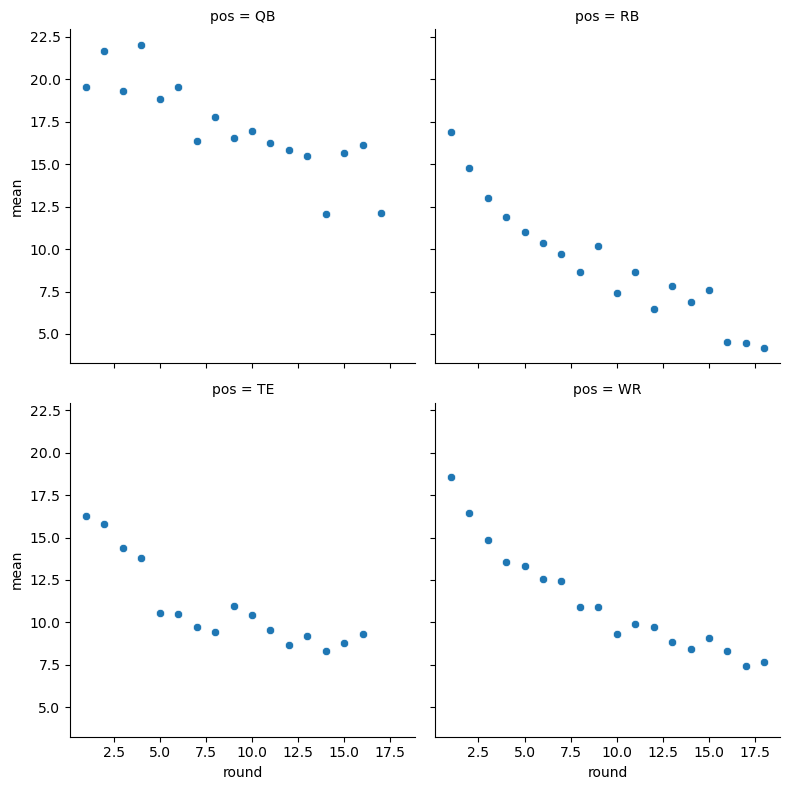

In [354]:
g = sns.FacetGrid(scts, col='pos', col_wrap=2, height=4)
g.map(sns.scatterplot, 'round', 'mean')
#g.map(sns.scatterplot, 'round', 'min', color='red', marker='_', s=200)
#g.map(sns.scatterplot, 'round', 'max', color='green', marker='_', s=200)
plt.show()

Ta-da! We have per round PPG averages for players of each position, from the last 10 seasons. The averages are organized by draft round. My instant conclusion is wow - we are pretty good at drafting! We seem to know where to draft the high-end players, as evidenced by the steep drop offs after the first few rounds, especially for RBs and WRs, who make up the majority of lineups. 

There is some noise as we get into later rounds, however, even though the average trend is downwards (as expected). Here is where we will find our edges.

Analysis to be continued...